In [546]:
import os
import xai
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.base import BaseEstimator, RegressorMixin
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, explained_variance_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.metrics import accuracy_score, plot_confusion_matrix, roc_auc_score, classification_report
from sklearn.metrics import log_loss, r2_score
import pickle
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge, SGDRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, VotingRegressor
from xgboost import XGBRegressor
from scipy.stats import gaussian_kde

mpl.rcParams['axes.unicode_minus'] = False

plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['font.size'] = 11.5
plt.rcParams['figure.figsize'] = (14,4)
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import FactorAnalysis, PCA

In [2]:
# starbucksDT = pd.read_excel('/Users/dhkim/PycharmProjects/starbucksDT/data/총합/fulldata_2020730.xlsx', sheet_name=1)

In [3]:
starbucksDT = pd.read_excel('/Users/dhkim/PycharmProjects/starbucksDT/data/총합/Fulldata_with_Clustering.xlsx')
starbucksDT = starbucksDT.drop(['Clustering1', '최근접_대기업명', '지난날짜_기준'], axis=1)
# starbucksDT['오픈일_지난날짜'] = starbucksDT['오픈일_지난날짜'].map(lambda x:x-37)

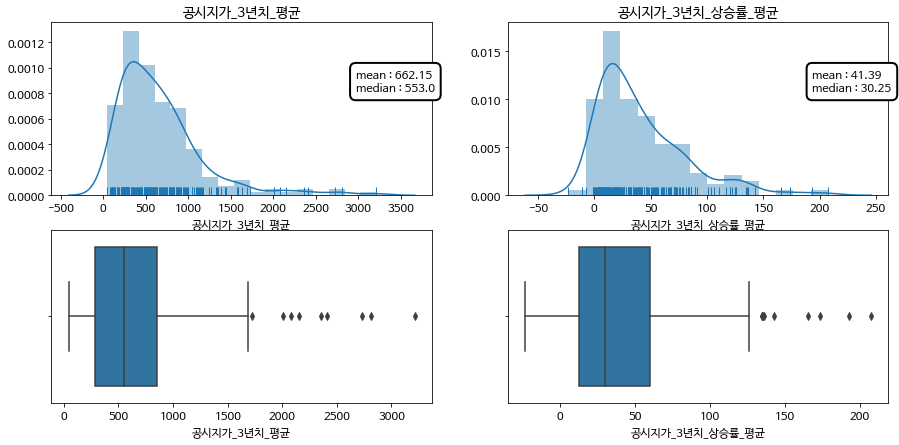

In [4]:
fig, axs = plt.subplots(nrows=2,ncols=2)
bbox_props = dict(boxstyle="round,pad=0.5", fc="w", ec="k", lw=2)
sns.distplot(starbucksDT['공시지가_3년치_평균'],rug=True, ax=axs[0,0])
sns.boxplot(starbucksDT['공시지가_3년치_평균'], ax=axs[1,0])
axs[0,0].set_title('공시지가_3년치_평균')
axs[0,0].annotate(f"mean : {starbucksDT['공시지가_3년치_평균'].mean():.2f}\nmedian : {starbucksDT['공시지가_3년치_평균'].median()}",
            xy=(0.8, 0.6),
            xycoords='axes fraction',
            xytext=(0.8, 0.6),
            bbox=bbox_props)
sns.distplot(starbucksDT['공시지가_3년치_상승률_평균'],rug=True, ax=axs[0,1])
sns.boxplot(starbucksDT['공시지가_3년치_상승률_평균'], ax=axs[1,1])
axs[0,1].set_title('공시지가_3년치_상승률_평균')
axs[0,1].annotate(f"mean : {starbucksDT['공시지가_3년치_상승률_평균'].mean():.2f}\nmedian : {starbucksDT['공시지가_3년치_상승률_평균'].median()}",
            xy=(0.8, 0.6),
            xycoords='axes fraction',
            xytext=(0.8, 0.6),
            bbox=bbox_props)
fig.set_size_inches((15,7))

In [5]:
starbucksDT['공시지가_3년치_상승률_평균'] = starbucksDT['공시지가_3년치_상승률_평균'].fillna(starbucksDT['공시지가_3년치_상승률_평균'].median())
starbucksDT['공시지가_3년치_평균'] = starbucksDT['공시지가_3년치_평균'].fillna(starbucksDT['공시지가_3년치_평균'].median())

In [259]:
def visualize_feature_importance(corr_df, label_cols, except_cols, threshold=0.15):
    df = corr_df.copy()
    num_cols = 2
    num_row, q = divmod(len(label_cols), num_cols)
    num_row += q
    fig, axs = plt.subplots(nrows=num_row, ncols=num_cols)
    bbox_props = dict(boxstyle="round,pad=0.5", fc="w", ec="k", lw=2)
    df_dict =  {'features':[],
                'values':[],
                'kinds':[]}
    top_values_dict = {}

    for idx, feature in enumerate(label_cols):
        if isinstance(except_cols, dict):
            temp_series = corr_df.loc[feature, corr_df.columns.map(lambda x:x not in except_cols[feature])]
        else:
            temp_series = corr_df.loc[feature, corr_df.columns.map(lambda x:x not in except_cols)]
        temp_series = temp_series[temp_series.abs().argsort()[::-1]]
        top_values = temp_series[0:20][temp_series[0:20].map(lambda x:np.abs(x)>=threshold)]
        if num_row > 1:
            ax = axs[idx//2, idx%2]
        else:
            ax = axs[idx]
        ax.set_title(f'{feature} 상관계수 시각화', y=1.05, x=0.5, size=14, color='black')
        try:
            sns.barplot(x=top_values.values, y=top_values.index, ax=ax)
            num_, mean_, max_ = len(top_values), np.round(top_values.abs().mean(), 2), np.round(top_values.abs().max(), 2)
            df_dict['features'].append(np.repeat([feature],3))
            df_dict['values'].append([num_, mean_, max_])
            df_dict['kinds'].append(['num','mean','max'])
            
            ax.annotate(f'{threshold} 이상 feature 개수 : {num_}\n{threshold} 이상 |feature| 평균 : {mean_}\n{threshold} 이상 feature 최댓값 : {max_}',
                                        xy=(0.8, 0.6),
                                        xycoords='axes fraction',
                                        xytext=(0.03, 0.02),
                                        bbox=bbox_props)
            top_values_dict[feature] = top_values
        except Exception as e:
            if len(top_values)==0:
                print(f'this {feature} has not important features')
            else:
                print(e)
    df_dict['features'] = np.concatenate(df_dict['features'])
    df_dict['values'] = np.concatenate(df_dict['values'])
    df_dict['kinds'] = np.concatenate(df_dict['kinds'])

    df_compare = pd.DataFrame(df_dict)
    fig.suptitle(f'종속변수 vs feature 상관계수 시각화 [{threshold} 이상]', y=1.05, x=0.5, size=24, color='black')
    fig.set_size_inches(19, 11)
    fig.tight_layout()
    visualize_feature_compare(df_compare, threshold)
    return df_compare, top_values_dict

def visualize_feature_compare(df, threshold):
    fig = plt.figure(figsize=(16,7))
    df_compare = df.copy()
    
    num_mask = df_compare.kinds == 'num'
    scale = df_compare.loc[num_mask, 'values'].median() / df_compare.loc[~num_mask, 'values'].abs().median()
    df_compare.loc[~num_mask, 'values'] = df_compare.loc[~num_mask, 'values'] * scale
    ax1 = sns.barplot(x='features',y='values',data=df_compare,hue='kinds')
    ax1.set_ylabel('feature 개수', fontsize=16)
    ax1.set_xlabel('종속변수 종류', fontsize=16)
    
    # Create a second y-axis with the scaled ticks
    ax2 = ax1.twinx()
    
    # Ensure ticks occur at the same positions, then modify labels
    ax2.set_ylim(ax1.get_ylim())
    ax2.set_yticklabels(np.round(ax1.get_yticks()/scale, 2))
    ax2.set_ylabel('|feature| 평균값 및 최댓값', fontsize=16)
    
    def add_bar_text(ax, num_length, scale):
        for idx, patch in enumerate(ax.patches):
            value = str(int(patch.get_height()))
            if idx > num_length-1:
                value = f'{patch.get_height()/scale:.2f}'
            ax.annotate(value, 
                        (patch.get_x() + patch.get_width() / 2., patch.get_height()), 
                        ha = 'center', va = 'center', 
                        xytext = (0, 9), 
                        textcoords = 'offset points')
    add_bar_text(ax1, np.sum(num_mask), scale)
    fig.suptitle(f'종속 변수에 따른 feature 상관계수 비교 [{threshold} 이상]', y=1.05, x=0.5, size=24, color='black')
    fig.tight_layout()
#     fig.suptitle(f'{feature} 상관계수 시각화', y=1.05, x=0.5, size=14, color='black')

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


def normalization_train_test(df_train, df_test, target_cols, method='standard', label_col_include=False):
    if method=='standard':
        sc = StandardScaler()
    elif method=='minmax':
        sc = MinMaxScaler()
    if label_col_include:
        target_cols = target_cols + [label_col_include]
    except_cols = df_train.loc[:, df_train.columns.map(lambda x:x not in target_cols)].columns
    
    df_train_sc = sc.fit_transform(df_train.loc[:, target_cols])
    df_test_sc = sc.transform(df_test.loc[:, target_cols])

    df_train_sc = pd.DataFrame(df_train_sc, columns=target_cols, index=list(df_train.index.values))
    df_test_sc = pd.DataFrame(df_test_sc, columns=target_cols, index=list(df_test.index.values))

    df_train_sc[except_cols] = df_train[except_cols]
    df_test_sc[except_cols] = df_test[except_cols]
    
    return df_train_sc, df_test_sc

class Kfold(object):
    def __init__(self, k=3):
        self.k = k
        self.train_scores = {}
        self.test_scores = {}
        self.train_errors = {}
        self.test_errors = {}
        self.data_idx_train = {}
        self.data_idx_test = {}
        self.best_model = {}
        self.best_train = {}
        self.best_test = {}
        self.cv = KFold(k, shuffle=True, random_state=0)
        
    @staticmethod
    def get_r2_score(y_true, y_pred):
        rss = ((y_true - y_pred) ** 2).sum()
        tss = ((y_true - y_true.mean())** 2).sum()
        rsquared = 1 - rss / tss
        return rsquared   
    
    @staticmethod
    def get_cross_val_score(model, df, train_features, label_feature, k, cv, normalization, task):
        data_idx_train = []
        data_idx_test = []
        train_scores = np.zeros(k)
        train_errors = np.zeros(k)
        test_scores = np.zeros(k)
        test_errors = np.zeros(k)
        
        for i, (idx_train, idx_test) in enumerate(cv.split(df)):
            df_train = df.iloc[idx_train]
            df_test = df.iloc[idx_test]
#             df_train, df_test = normalization_train_test(df_train, df_test, target_cols=train_features,
#                                                          method=normalization, label_col_include=label_feature)

            model = model.fit(df_train[train_features], df_train[label_feature])
            data_idx_train.append(idx_train)
            data_idx_test.append(idx_test)
            if task=='regression':
                train_score = Kfold.get_r2_score(df_train[label_feature], model.predict(df_train[train_features]))
                test_score = Kfold.get_r2_score(df_test[label_feature], model.predict(df_test[train_features]))
                train_error = mean_squared_error(df_train[label_feature], model.predict(df_train[train_features]))
                test_error = mean_squared_error(df_test[label_feature], model.predict(df_test[train_features]))
            elif task=='classification':
                train_score = accuracy_score(df_train[label_feature], model.predict(df_train[train_features]))
                test_score = accuracy_score(df_test[label_feature], model.predict(df_test[train_features]))
                train_error = mean_squared_error(df_train[label_feature], model.predict(df_train[train_features]))
                test_error = mean_squared_error(df_test[label_feature], model.predict(df_test[train_features]))
                
            train_scores[i] = train_score
            test_scores[i] = test_score
            train_errors[i] = train_error
            test_errors[i] = test_error
        
#         print("학습 평균 score = {:.8f}, 검증 평균 score = {:.8f}".format(np.mean(train_scores), np.mean(test_scores)))
        return train_scores, test_scores, train_errors, test_errors, data_idx_train, data_idx_test
    
    def cross_val(self, model_name, model, df, train_features, label_feature, normalization='minmax', task='classification'):
        if normalization == 'minmax':
            model = Pipeline([('scaler', MinMaxScaler()),('model_name', model)])
        else:
            model = Pipeline([('scaler', StandardScaler()),('model_name', model)])
        values = Kfold.get_cross_val_score(model, df, train_features, label_feature, self.k, self.cv, normalization, task)
        self.train_scores[model_name] = values[0]
        self.test_scores[model_name] = values[1]
        self.train_errors[model_name] = values[2]
        self.test_errors[model_name] = values[3]
        self.data_idx_train[model_name] = values[4]
        self.data_idx_test[model_name] = values[5]
#         print(f'{"*"*15} {label_feature} complete {"*"*15}\n')
        return model
    
    def best_visualize(self, model_name, model, df, train_features, label_feature, normalization):
        data_idx_train = self.data_idx_train[model_name]
        data_idx_test = self.data_idx_test[model_name]
        
        total_scores = self.train_scores[model_name] + self.test_scores[model_name]
        arg_best = np.argmax(total_scores)
        best_train = df.iloc[data_idx_train[arg_best]]
        best_test = df.iloc[data_idx_test[arg_best]]
        self.best_train[model_name] = best_train
        self.best_test[model_name] = best_test
        best_train, best_test = normalization_train_test(best_train, best_test, target_cols=train_features,
                                                         method=normalization, label_col_include=label_feature)
        x_train, y_train = best_train[train_features], best_train[label_feature]
        x_test, y_test = best_test[train_features], best_test[label_feature]
        
        best_model = model
        best_model = best_model.fit(x_train, y_train)
        self.best_model[model_name] = best_model
        fig, axs = plt.subplots(2, 2)
        Kfold.visualize_result(y_test, best_model.predict(x_test), axs[0, :], 'test data',
                               model_title=model_name, label_name=label_feature, etc=self.k,
                               score=self.test_scores[model_name][arg_best])
        Kfold.visualize_result(y_train, best_model.predict(x_train), axs[1, :], 'train data',
                               model_name, label_name=label_feature, etc=self.k,
                               score=self.train_scores[model_name][arg_best])
        fig.suptitle(f'{model_name} results [target : {label_feature}]', y=1.05, x=0.5, size=24, color='black')
        fig.set_size_inches(16, 10)
        fig.tight_layout()
        
    @staticmethod
    def reset_param():
        mpl.rcParams['axes.unicode_minus'] = False
        plt.rcParams['font.family'] = 'NanumBarunGothic'
        plt.rcParams['font.size'] = 11.5
        plt.rcParams['figure.figsize'] = (5,3)
    
    @staticmethod
    def visualize_result(y_test, y_pred, axs, title='test data', model_title='linearmodel',label_name='Y', etc='3', score=None):
        if score == None:
            score = r2_score(y_test, y_pred)
        sns.lineplot(x=np.arange(0, len(y_test), 1),y=y_test, color = 'red', label = 'Real data', ax=axs[0])
        sns.lineplot(x=np.arange(0, len(y_pred), 1),y=y_pred, color = 'blue', label = 'Predicted data', ax=axs[0])
        axs[0].set_title(f'{etc}fold {model_title} {label_name} Prediction {title}')
        Kfold.visualize_linear(y_test, y_pred, axs[1], label_name, title, score)
#         Kfold.reset_param()

    @staticmethod
    def visualize_linear(y_test, y_pred, ax, label_name, title, score):
        bbox_props = dict(boxstyle="round,pad=0.5", fc="w", ec="k", lw=2)
        ax.annotate(f'best {title} \n r2 score {np.round(score,3)}',
                    xy=(0.8, 0.6),
                    xycoords='axes fraction',
                    xytext=(0.04, 0.75),
                    bbox=bbox_props,
                    size=14)
        sns.scatterplot(y_test, y_pred, color = 'blue', ax=ax)
        x_len = len(y_test)
        x = np.linspace(0,1,x_len)
        sns.lineplot(x, x, color = 'red', label = 'ideal', ax=ax)
        ax.set_xlabel(f"{label_name}" + " : $Y_i$")
        ax.set_ylabel(f"Predicted {label_name}: " + "$\hat{Y}_i$")
        ax.set_title(f"Real {label_name} vs Predicted {label_name}" + " : $Y_i$ vs $\hat{Y}_i$")
#         plt.show()        
        
class StatsmodelsOLS(BaseEstimator, RegressorMixin):
    def __init__(self, formula):
        self.formula = formula
        self.model = None
        self.data = None
        self.result = None
        
    def fit(self, dfX, dfy):
        self.data = pd.concat([dfX, dfy], axis=1)
        self.model = smf.ols(self.formula, data=self.data)
        self.result = self.model.fit()
        
    def predict(self, new_data):
        return self.result.predict(new_data)
    
def add_bar_text(ax):
    for idx, patch in enumerate(ax.patches):
        value = f'{patch.get_height()}'
        ax.annotate(value, 
                    (patch.get_x() + patch.get_width() / 2., patch.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points')

def supervised_modeling(df, model, model_name, feature_names, target_labels, normalization='minmax', task='regression', k_values=[5], metric='r2_score'):
    kfolds = {}
    kfold_scores = {}
    kfold_scores['label'] = []
    kfold_scores['values'] = []
    kfold_scores['kind'] = []
    kfold_scores['model_name'] = []
    kfold_scores['k'] = []
    
    for target_label in target_labels:
        if isinstance(feature_names, dict):
            feature_names_for_label = feature_names[target_label]
        else:
            feature_names_for_label = feature_names
        kfolds[target_label] = []
        for idx, k in enumerate(k_values):
            kfold = Kfold(k)
            model = kfold.cross_val(model_name, model, df, feature_names_for_label, target_label, normalization=normalization, task=task)
            kfold_scores['label'].append(np.repeat([target_label], k*2))
            kfold_scores['values'].append(np.concatenate([kfold.train_scores[model_name], kfold.test_scores[model_name]]))
            kfold_scores['kind'].append(np.concatenate([np.repeat(['train'], k), np.repeat(['test'], k)]))
            kfold_scores['model_name'].append(np.repeat([model_name], k*2))
            kfold_scores['k'].append(np.repeat([k], k*2))
            kfolds[target_label].append(kfold)
        k_mean = np.asarray(list(map(lambda x:np.mean(x),kfold_scores['values'])))
        arg_max = np.argmax(np.mean(k_mean))
#         print(f'{model_name}`s k={kfolds[target_label][arg_max].k} is best for {target_label}\n')
        kfolds[target_label][arg_max].best_visualize(model_name, model, df, feature_names_for_label, target_label, normalization)

    for k,v in kfold_scores.items():
        kfold_scores[k] = np.concatenate(v)

     
    kfold_score_df = pd.DataFrame(kfold_scores)
    if len(target_labels) == 2:
        fig, axs = plt.subplots(2, len(k_values))
        kfold_score_df1 = kfold_score_df.loc[kfold_score_df['label']==target_labels[0], :]
        kfold_score_df2 = kfold_score_df.loc[kfold_score_df['label']!=target_labels[0], :]
        bbox_props = dict(boxstyle="round,pad=0.5", fc="w", ec="k", lw=2)
        for idx, df in enumerate([kfold_score_df1, kfold_score_df2]):
            for i, k in enumerate(k_values):
                if len(k_values) == 1:
                    ax=axs[idx]
                else:
                    ax=axs[idx, i]
                sns.barplot(x=df[df.k==k].index,y='values',hue='kind',data=df[df.k==k], ax=ax)
                ax.set_title(f"target : {target_labels[idx]}\nk={k}")
                ax.annotate(f'mean {metric}\n'
                            f'train : {np.round(df[(df.k==k)&(df.kind=="train")]["values"].mean(),3)}\n'
                            f'test : {np.round(df[(df.k==k)&(df.kind=="test")]["values"].mean(),3)}',
                            xy=(0.8, 0.6),
                            xycoords='axes fraction',
                            xytext=(0.94, 0.9),
                            bbox=bbox_props,
                            size=12)
            
    else:
        fig, axs = plt.subplots(1, len(k_values))
        kfold_score_df1 = kfold_score_df.loc[kfold_score_df['label']==target_labels[0], :]
        bbox_props = dict(boxstyle="round,pad=0.5", fc="w", ec="k", lw=2)

        for i, k in enumerate(k_values):
            if len(k_values) == 1:
                ax=axs
            else:
                ax=axs[i]
            sns.barplot(x=kfold_score_df1[kfold_score_df1.k==k].index,y='values',hue='kind',data=kfold_score_df1[kfold_score_df1.k==k], ax=ax)
            ax.set_title(f"target : {target_labels[0]}\nk={k}")
            ax.annotate(f'mean {metric}\n'
                        f'train : {np.round(kfold_score_df1[(kfold_score_df1.k==k)&(kfold_score_df1.kind=="train")]["values"].mean(),3)}\n'
                        f'test : {np.round(kfold_score_df1[(kfold_score_df1.k==k)&(kfold_score_df1.kind=="test")]["values"].mean(),3)}',
                        xy=(0.8, 0.6),
                        xycoords='axes fraction',
                        xytext=(0.94, 0.9),
                        bbox=bbox_props,
                        size=12)

    fig.suptitle(f'k-fold cross validation R2 scores', y=1.05, x=0.5, size=14, color='black')
    fig.set_size_inches(len(k_values)*7, 6)
    fig.tight_layout()
        
    return kfolds, kfold_score_df

In [8]:
class StarbucksDT(object):
    def __init__(self, df, label_col):
        self.trip = df.loc[df[label_col]=='관광',:].reset_index(drop=True)
        self.company = df.loc[df[label_col]=='사업체',:].reset_index(drop=True)
        self.IC = df.loc[df[label_col]=='IC근처',:].reset_index(drop=True)
        self.apt = df.loc[df[label_col]=='아파트',:].reset_index(drop=True)
stDT = StarbucksDT(starbucksDT, '분류')

In [9]:
def draw_all_features(feature_nums, num_cols, feature_df):
    num_rows = int(np.ceil(feature_nums / num_cols))
    print(f'num_rows, num_cols : {num_rows}, {num_cols}')
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(25,25))
    for idx, col in enumerate(feature_df.columns[1:]):
        r, c = divmod(idx, num_cols)
        try:
            sns.boxplot(feature_df[col], ax=axs[r,c])
            axs[r,c].set_title(col)
        except:
            axs[r,c].set_title(col)
            continue
    fig.tight_layout()

def minmax_norm(df, row, col_name):
    return (row[col_name] - df[col_name].min())/(df[col_name].max() - df[col_name].min())

def upper_outliers_iqr(df, col_name, min_per, max_per):
    upper_bound, lower_bound = get_bound_wrt_iqr(df[col_name], min_per, max_per)
    max_value = df.reset_index(drop=True).loc[np.where((df[col_name] <= upper_bound))][col_name].values.max()
    return np.concatenate(np.where((df[col_name] > upper_bound))), max_value

def get_bound_wrt_iqr(data, min_per, max_per):
    quartile_1, quartile_3 = np.percentile(data, [min_per, max_per])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return lower_bound, upper_bound

def down_outliers_iqr(df, col_name, min_per, max_per):
    upper_bound, lower_bound = get_bound_wrt_iqr(df[col_name], min_per, max_per)
    min_value = df.reset_index(drop=True).loc[np.where((df[col_name] >= lower_bound))][col_name].values.min()
    return np.concatenate(np.where((df[col_name] < lower_bound))), min_value

def outlier_make_one_value(df, col_name, min_per=25, max_per=75):
    temp_df = df.copy()
    outlier_up_idx, one_max = upper_outliers_iqr(temp_df, col_name, min_per, max_per)
    temp_df = temp_df.reset_index(drop=True)
    temp_df.loc[outlier_up_idx, col_name] = one_max
    outlier_dw_idx, one_min = down_outliers_iqr(temp_df, col_name, min_per, max_per)
    temp_df.loc[outlier_dw_idx, col_name] = one_min
    sns.boxplot(temp_df[col_name])
    return temp_df

def check_box_plot(src_df, target_df, col_name):
    plt.figure(figsize=(14,4))
    sns.boxplot(src_df[col_name])
    plt.figure(figsize=(14,4))
    target_df = outlier_make_one_value(target_df, col_name)
    return target_df

In [10]:
class OutlierHandler(object):
    def __init__(self):
        self.outliers_map = {}
        self.changed_col_map = {}
        
    def percentile_based_outlier(self, data, threshold=95):
        diff = (100 - threshold) / 2.0
        (minval, maxval) = np.percentile(data, [diff, 100 - diff])
        return ((data < minval) | (data > maxval))
    
    def iqr_based_outlier(self, data, min_per=25, max_per=75):
        quartile_1, quartile_3 = np.percentile(data, [min_per, max_per])
        iqr = quartile_3 - quartile_1
        lower_bound = quartile_1 - (iqr * 1.5)
        upper_bound = quartile_3 + (iqr * 1.5)
        return ((data < lower_bound) | (data > upper_bound))
    
    def mad_based_outlier(self, points, threshold=3.5):
        if len(points.shape) == 1:
            points = points[:, np.newaxis]
        median_y = np.median(points)
        median_absolute_deviation_y = np.median([np.abs(y-median_y) for y in points])
        modified_z_scores = [0.6745 * (y-median_y) / median_absolute_deviation_y for y in points]

        return np.reshape(np.abs(modified_z_scores) >= threshold, (-1))

    def std_based_outlier(self, data, threshold=3):
        std = data.std()
        mean = data.mean()
        isOutlier = []
        for val in data:
            if np.abs(val-mean)/std >= threshold:
                isOutlier.append(True)
            else:
                isOutlier.append(False)
        return np.asanyarray(isOutlier)

    def voting_based_outlier(self, data, agree=2):
        x = self.percentile_based_outlier(data)[:,np.newaxis]
        y = self.mad_based_outlier(data)[:,np.newaxis]
        z = self.std_based_outlier(data)[:,np.newaxis]
        w = self.iqr_based_outlier(data)[:,np.newaxis]
        temp = np.concatenate([data.index[:,np.newaxis], x, y, z, w], axis=-1)
        final = []
        for i in range(temp.shape[0]):
            if list(temp[i, :]).count(True) >= agree:
                printing =  f' outlier voting...'
                for idx in range(temp.shape[-1]-1):
                    if (idx==0) and (temp[i, idx+1] == True):
                        printing += 'percentile, '
                    if (idx==1) and (temp[i, idx+1] == True):
                        printing += 'mad, '
                    if (idx==2) and (temp[i, idx+1] == True):
                        printing += 'std_div, '
                    if (idx==3) and (temp[i, idx+1] == True):
                        printing += 'iqr, , '
#                 print(f'{temp[i, 0]}th idx data, {printing}')
                final.append(True)
            else:
                final.append(False)
        return final
    
    def voting1half_based_outlier(self, data):
#         print(f'voting1half_based_outlier...')
        return self.voting_based_outlier(data, 2)
        
    def voting3quarter_based_outlier(self, data):
#         print(f'voting3quarter_based_outlier...')
        return self.voting_based_outlier(data, 3)

    def plotOutlier(self, x, draw=True):
        if not draw:
            return self.genOutlier(x)
        
        functions = [self.iqr_based_outlier,
                     self.percentile_based_outlier,
                     self.mad_based_outlier,
                     self.std_based_outlier,
                     self.voting1half_based_outlier,
                     self.voting3quarter_based_outlier]
        
        fig, axes = plt.subplots(nrows=len(functions), ncols=2)
        kwargs = dict(y=1.05, x=0.01, ha='left', va='center', size=20, color='blue')
        self.outliers_map[x.name] = {}
        median = x.median()
        
        for ax, func in zip(axes[:, 0], functions):
            sns.distplot(x.values, ax=ax, rug=True, hist=True)
            outliers = x[func(x)]
            ax.plot(outliers, np.zeros_like(outliers), 'ro', clip_on=False)
            func_name = f"{str(func).split(' ')[2].split('.')[1]}"
            ax.set_title(func_name, **kwargs)
            self.outliers_map[x.name][func_name] = outliers
            top_outlier = list(outliers.values > median).count(True)
            bot_outlier = len(outliers.values) - top_outlier
            bbox_props = dict(boxstyle="round,pad=0.5", fc="w", ec="k", lw=2)
            ax.annotate(f'top out count : {top_outlier}\nbot out count : {bot_outlier}',
                        xy=(0.8, 0.6),
                        xycoords='axes fraction',
                        xytext=(0.8, 0.6),
                        bbox=bbox_props)

        for ax, outlier in zip(axes[:, 1], self.outliers_map[x.name].values()):
            sns.boxplot(x.values, ax=ax)
            ax.plot(outlier, np.zeros_like(outlier), 'ro', clip_on=False)

        self.outliers_map[x.name]['median'] = median           
        fig.suptitle('Comparing Ourlier Tests with {}, n={}'.format(x.name, len(x)), y=1.03, x=0.5, size=24, color='black')
        axes[-1, 0].set_xlabel(f'{x.name}', fontsize=12)
        axes[-1, 1].set_xlabel(f'{x.name}', fontsize=12)
        fig = plt.gcf()
        fig.set_size_inches(16, 13)
        fig.tight_layout()

    def genOutlier(self, x):
        functions = [self.iqr_based_outlier,
                     self.percentile_based_outlier,
                     self.mad_based_outlier,
                     self.std_based_outlier,
                     self.voting1half_based_outlier,
                     self.voting3quarter_based_outlier]
        
        self.outliers_map[x.name] = {}
        median = x.median()
        
        for func in functions:
            outliers = x[func(x)]
            func_name = f"{str(func).split(' ')[2].split('.')[1]}"
            self.outliers_map[x.name][func_name] = outliers
            top_outlier = list(outliers.values > median).count(True)
            bot_outlier = len(outliers.values) - top_outlier
            
        self.outliers_map[x.name]['median'] = median           
        
    def replace_outlier(self, df, col_name, select_mode='voting3quarter_based_outlier', draw=True):
        replaced_df = df.copy()

        upper_outliers = self.outliers_map[col_name][select_mode][self.outliers_map[col_name][select_mode] >= self.outliers_map[col_name]['median']]
        lower_outliers = self.outliers_map[col_name][select_mode][self.outliers_map[col_name][select_mode] < self.outliers_map[col_name]['median']]

        df_except_upper_mask = df.index.map(lambda x:x not in upper_outliers.index)
        df_except_lower_mask = df.index.map(lambda x:x not in lower_outliers.index)

        df_except_upper = df.loc[df_except_upper_mask, col_name]
        df_except_lower = df.loc[df_except_lower_mask, col_name]

        supremum = df_except_upper.max()
        infimum = df_except_lower.min()

        replaced_df.loc[df_except_upper_mask.map(lambda x:not x), col_name] = supremum
        replaced_df.loc[df_except_lower_mask.map(lambda x:not x), col_name] = infimum
        
        if draw:
            fig, axs = plt.subplots(nrows=1,ncols=2)
            sns.distplot(df[col_name], rug=True, ax=axs[0])
            axs[0].set(title='before outlier handling')
            sns.distplot(replaced_df[col_name], rug=True, ax=axs[1])
            axs[1].set(title='after outlier handling')

            fig = plt.gcf()
            fig.tight_layout()
        
        return replaced_df
    
#         temp_df = df.copy()
#         median = temp_df[col_name].median()
#         up_values = outliers[outliers>=median]
#         down_values = outliers[outliers<median]
#         np.where(temp_df[col_name].values < up_v

In [11]:
stDT.IC.columns

Index(['지점명', '분류', '위도', '경도', 'M', 'Tu', 'W', 'Th', 'Fr', 'Sa', 'S', '00~03',
       '03~06', '06~09', '09~12', '12~15', '15~18', '18~21', '12~24', 'M_20',
       'M_25', 'M_29', 'M_34', 'M_39', 'M_44', 'M_49', 'M_54', 'M_59', 'M_60',
       'W_20', 'W_25', 'W_29', 'W_34', 'W_39', 'W_44', 'W_49', 'W_54', 'W_59',
       'W_60', '관광지명', '관광지_거리', '관광지_리뷰수', '교통량_점수', '교통량_점수_아침', '교통량_점수_저녁',
       '교통량_점수_점심', '교통량_점수_주말', '교통량_점수_평일', '맥도날드_거리', '인근_스타벅스_거리',
       '아파트_거리', '아파트_매매가_상한', '아파트_세대수', '아파트_준공년월', '인근_교차로_거리(m)',
       '주유소_거리(m)', '1년_영수증_개수', '6개월_영수증_개수', '3개월_영수증_개수', '2개월_영수증_개수',
       '1개월_영수증_개수', '1년_점수', '6개월_점수', '3개월_점수', '2개월_점수', '1개월_점수',
       '최근접_대기업_거리', '최근접_대기업_자본금', '1km내_대기업_개수', '2km내_대기업_개수',
       '3km내_대기업_개수', '5km내_대기업_개수', '리뷰점수', '동단위_아파트_세대수', 'Label',
       '공시지가_3년치_평균', '공시지가_3년치_상승률_평균', '오픈일_지난날짜', '오픈일'],
      dtype='object')

In [12]:
outlier_handler = OutlierHandler()

## 유동인구 관련 변수 outlier 처리

### outlier를 확인해본 결과 critical 하지 않아, voting3quarter_based_outlier 방식으로 처리한다. 

In [13]:
replaced_df = stDT.IC.copy()

In [14]:
for col in ['M', 'Tu', 'W', 'Th', 'Fr', 'Sa', 'S',
'00~03', '03~06', '06~09', '09~12', '12~15', '15~18', '18~21', '12~24',
'M_20', 'M_25', 'M_29', 'M_34', 'M_39', 'M_44', 'M_49', 'M_54', 'M_59',
'M_60', 'W_20', 'W_25', 'W_29', 'W_34', 'W_39', 'W_44', 'W_49', 'W_54',
'W_59', 'W_60']:
    outlier_handler.plotOutlier(replaced_df[col], False)
    prev = replaced_df.copy()
    replaced_df = outlier_handler.replace_outlier(replaced_df, col, 'voting3quarter_based_outlier', False)
    if np.sum(prev[col]!=replaced_df[col]) > 0:
        outlier_handler.changed_col_map[col] = [prev[col], replaced_df[col]]

## time중 바뀐 feature들

In [15]:
outlier_handler.changed_col_map.keys()

dict_keys(['Sa', 'S', '03~06', '06~09', '18~21', '12~24', 'M_20', 'M_25', 'M_44', 'M_49', 'M_54', 'M_60', 'W_20', 'W_25', 'W_29', 'W_49', 'W_60'])

## 나머지 outlier 처리

### 혹시모르니 time_outlier 처리한 dataframe만 따로 저장해두기

In [16]:
replaced_df_timeonly = replaced_df.copy()

### 오픈일 지난날짜는 수치상으론 outlier가 있으나 분포가 고르게 보이므로 수정하지 않는다.

/Users/dhkim/.pyenv/versions/3.7.0/envs/xai/lib/python3.7/site-packages/matplotlib-3.0.2-py3.7-macosx-10.15-x86_64.egg/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


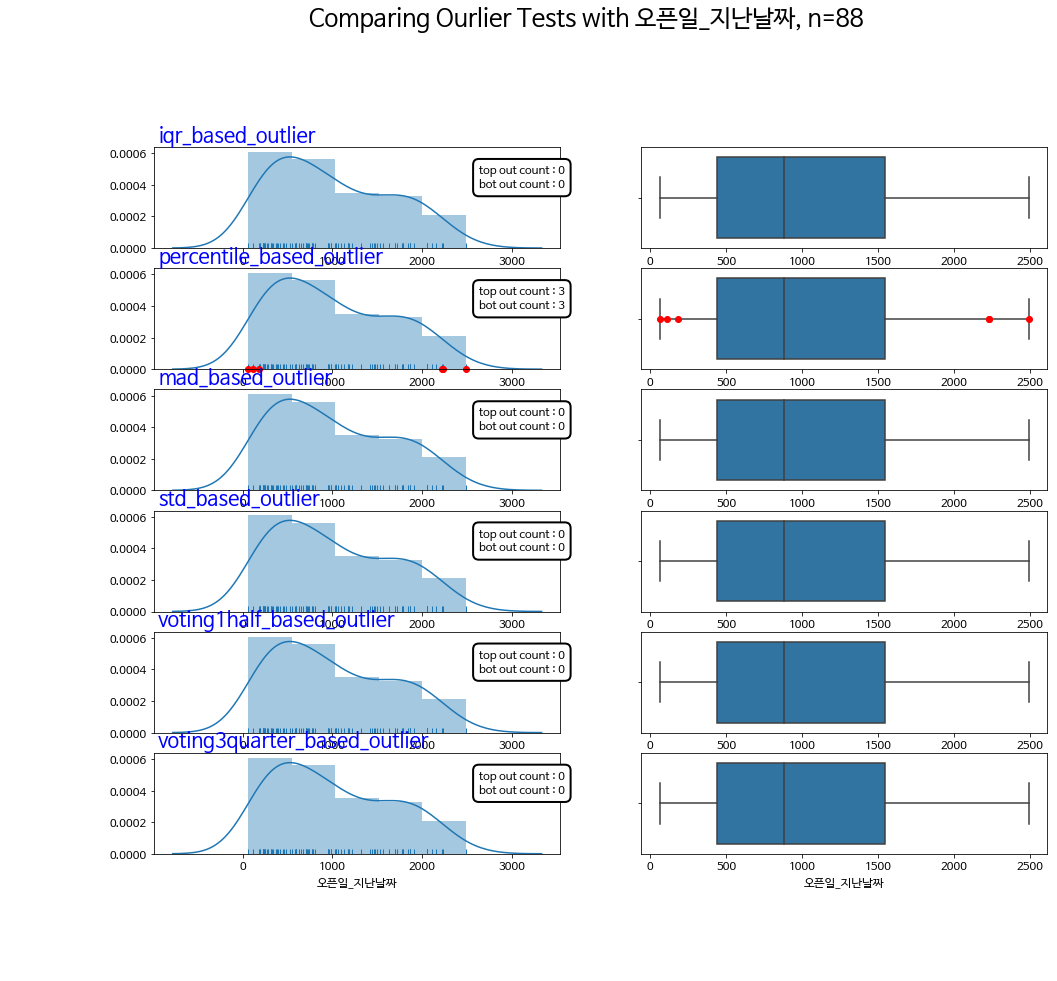

In [17]:
outlier_handler.plotOutlier(replaced_df['오픈일_지난날짜'])

In [18]:
for col in ['관광지_거리', '관광지_리뷰수', '교통량_점수', '교통량_점수_아침',
       '교통량_점수_저녁', '교통량_점수_점심', '교통량_점수_주말', '교통량_점수_평일', '맥도날드_거리',
       '인근_스타벅스_거리', '아파트_거리', '아파트_매매가_상한', '아파트_세대수', '아파트_준공년월',
       '인근_교차로_거리(m)', '주유소_거리(m)',
       '최근접_대기업_거리', '최근접_대기업_자본금',
       '3km내_대기업_개수', '5km내_대기업_개수', '동단위_아파트_세대수',
       '공시지가_3년치_평균', '공시지가_3년치_상승률_평균']:
    outlier_handler.plotOutlier(replaced_df[col], draw=False)
    prev = replaced_df.copy()
    replaced_df = outlier_handler.replace_outlier(replaced_df, col, 'voting1half_based_outlier', draw=False)
    if np.sum(prev[col]!=replaced_df[col]) > 0:
        outlier_handler.changed_col_map[col] = [prev[col], replaced_df[col]]

## outlier_handler내 replace_outlier를 이용해 대체된 column들의 분포만을 가시화해주는 함수

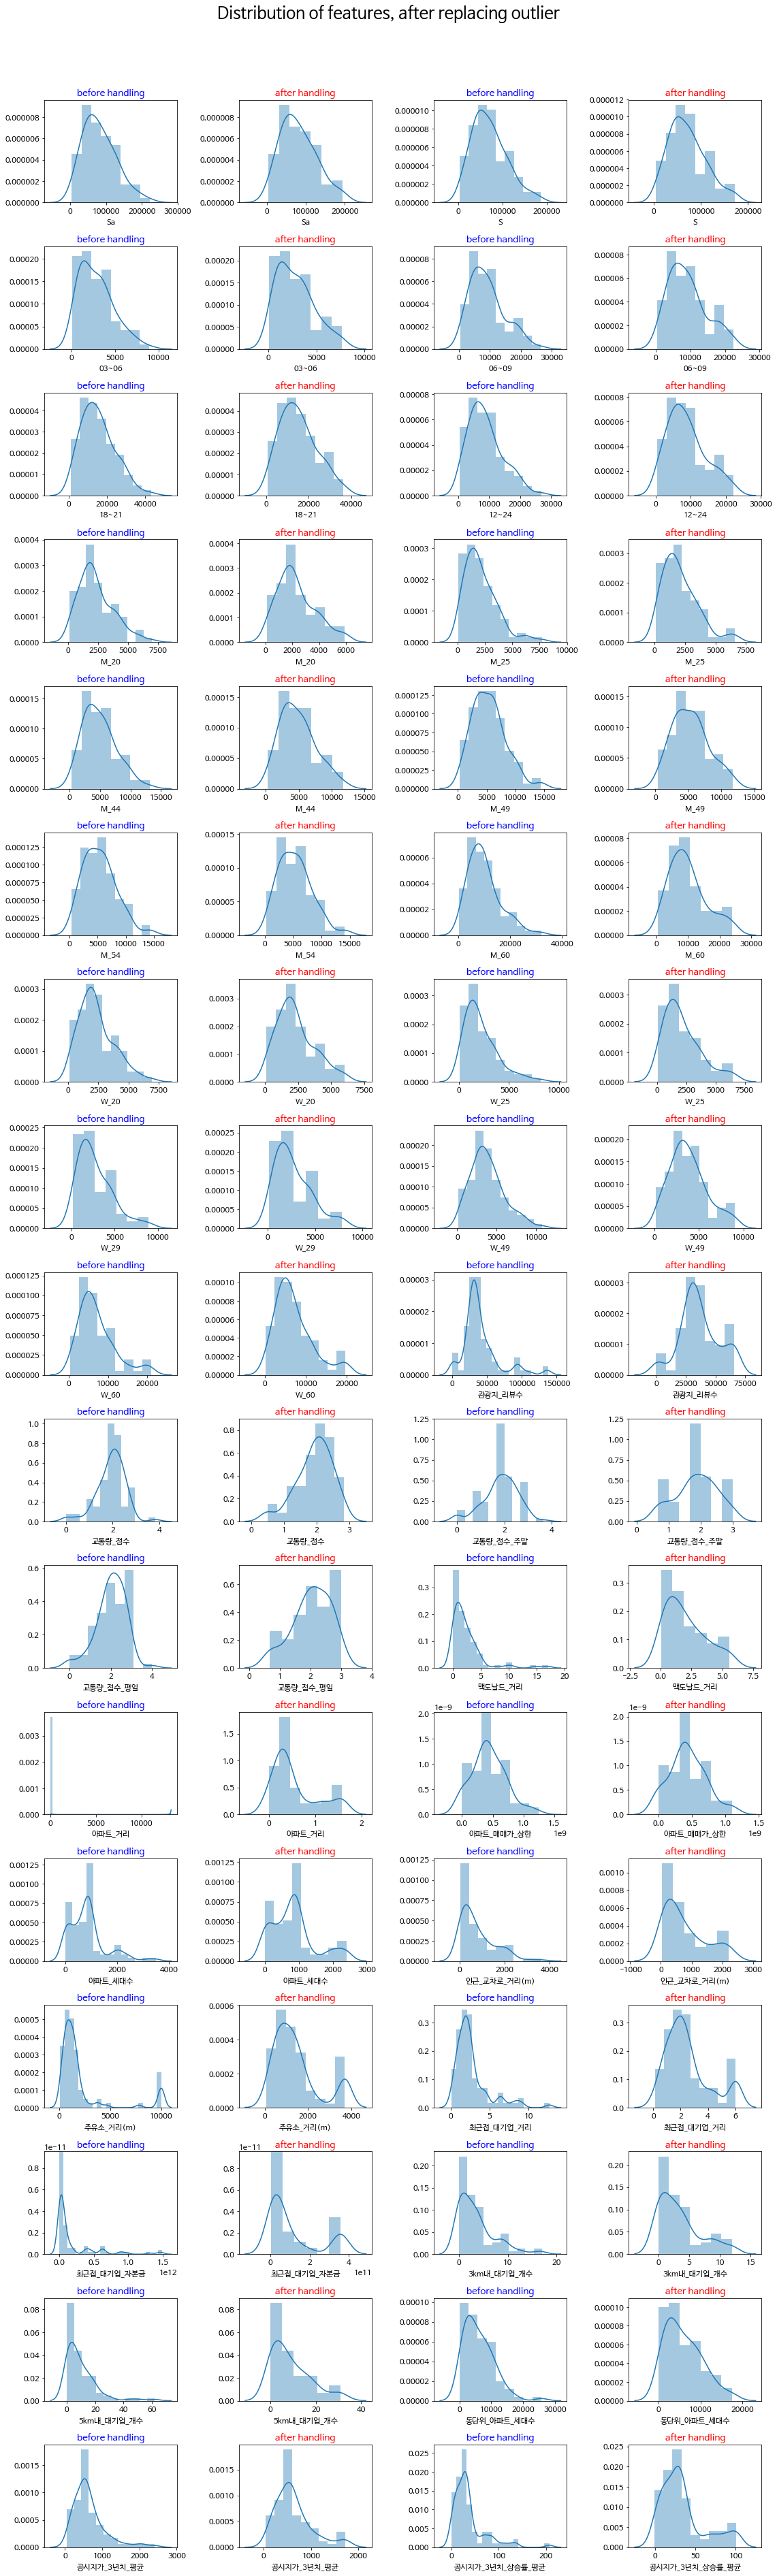

In [24]:
feature_length, q = divmod(len(outlier_handler.changed_col_map.keys()), 2)
feature_length += q

fig, axs = plt.subplots(feature_length, 4)
for idx1, col in enumerate(outlier_handler.changed_col_map.keys()):
    rownum, colnum = divmod(idx1, 2)
    col_map = {0:[0,1],1:[2,3]}
    for idx2, (colnum2, series) in enumerate(zip(col_map[colnum], outlier_handler.changed_col_map[col])):
        ax = axs[rownum, colnum2]
        sns.distplot(series, ax=ax)
        if idx2==0:
            ax.set_title(f'before handling', color='blue')
        else:
            ax.set_title(f'after handling', color='red')
            
fig.suptitle('Distribution of features, after replacing outlier', y=1.03, x=0.5, size=24, color='black')
fig = plt.gcf()
fig.set_size_inches(16, np.ceil(len(outlier_handler.changed_col_map.keys())*1.5))
fig.tight_layout()

## 관광데이터 outlier 수정후 상관관계 재분석

In [26]:
kfold_model = {'total':{},
               'trip':{},
               'IC':{},
               'apt':{},
               'company':{}}
kfold_results = {'trip':{},
                 'IC':{},
                 'apt':{},
                 'company':{}}
models = {
    'linear' : LinearRegression(),
    'lasso' : Lasso(),
    'ridge' : Ridge(),
    'sgd' : SGDRegressor(),
    'svr' : SVR(),
    'decisionTree' : DecisionTreeRegressor(),
    'extraTree' : ExtraTreeRegressor(),
    'randomForest' : RandomForestRegressor(),
    'adaBoost' : AdaBoostRegressor(),
    'gradientBoosting' : GradientBoostingRegressor(),
    'xgboost' : XGBRegressor()
}

## all feature

In [27]:
init_models = {
#     'linear' : LinearRegression(),
    'randomForest' : RandomForestRegressor(random_state=0),
}

In [33]:
replaced_df.shape

(88, 79)

['M', 'Tu', 'W', 'Th', 'Fr', 'Sa', 'S', '00~03', '03~06', '06~09', '09~12', '12~15', '15~18', '18~21', '12~24', 'M_20', 'M_25', 'M_29', 'M_34', 'M_39', 'M_44', 'M_49', 'M_54', 'M_59', 'M_60', 'W_20', 'W_25', 'W_29', 'W_34', 'W_39', 'W_44', 'W_49', 'W_54', 'W_59', 'W_60', '관광지_거리', '관광지_리뷰수', '교통량_점수', '교통량_점수_아침', '교통량_점수_저녁', '교통량_점수_점심', '교통량_점수_주말', '교통량_점수_평일', '맥도날드_거리', '인근_스타벅스_거리', '아파트_거리', '아파트_매매가_상한', '아파트_세대수', '아파트_준공년월', '인근_교차로_거리(m)', '주유소_거리(m)', '최근접_대기업_거리', '최근접_대기업_자본금', '1km내_대기업_개수', '2km내_대기업_개수', '3km내_대기업_개수', '5km내_대기업_개수', '동단위_아파트_세대수', '공시지가_3년치_평균', '공시지가_3년치_상승률_평균', '오픈일_지난날짜']
trip_all_model_results


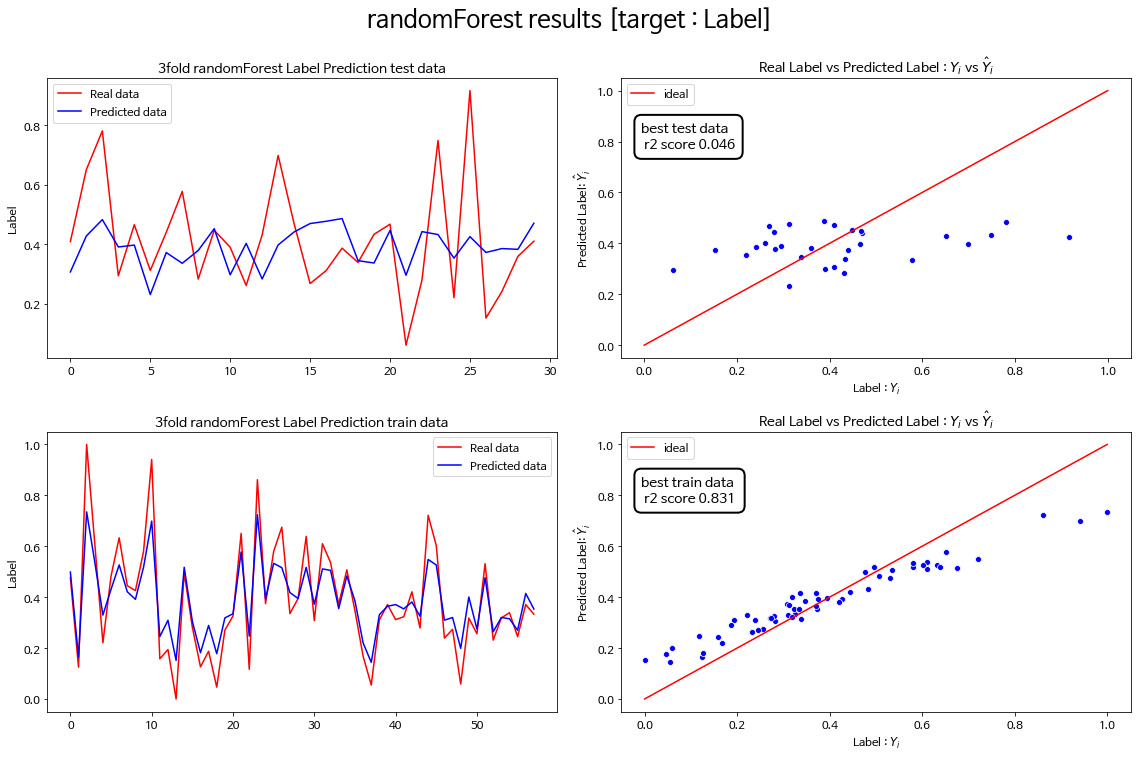

In [32]:
except_cols = replaced_df.loc[:, replaced_df.columns.map(lambda x:('지점명' == x) or ('오픈일' == x) or ('분류' == x) or ('경도' == x) 
                                                         or ('위도' == x) or ('1년' in x) or ('관광지명' == x) or ('최근접_대기업명' == x) 
                                                         or ('개월' in x) or ('Label' in x) or ('리뷰점수' == x) or ('영수증' in x))].columns
feature_names = list(replaced_df.loc[:, replaced_df.columns.map(lambda x:x not in except_cols)].columns)
print(feature_names)
target_labels = ['Label']
feature_names_dict_all = {} #0.15이상 feature 정의
for label in target_labels:
    feature_names_dict_all[label] = feature_names
kfold_model['trip_all'] = {}
kfold_results['trip_all'] = {}
print('trip_all_model_results')
for model_name, model in init_models.items():
    kfold_model['trip_all'][model_name], kfold_results['trip_all'][model_name] = supervised_modeling(replaced_df, model, model_name, feature_names_dict_all, target_labels, k_values=[3])

In [46]:
x_train = replaced_df[feature_names_dict_all['Label']]
y_train = replaced_df['Label']
feature = feature_names_dict_all['Label']

## feature selection and modeling ( corr > 0.15)

In [282]:
def ready_feature_col_wrt_corr(df, label_cols):
    corr_df = df.corr()
    feature_cols = {'all':{}, '015':{}, '02':{}}
    except_cols = {}
    except_cols_base = list(df.loc[:, df.columns.map(lambda x:('지점명' == x) or ('오픈일' == x) or ('분류' == x) or ('경도' == x) 
                                                             or ('위도' == x) or ('1년' in x) or ('관광지명' == x) or ('최근접_대기업명' == x) 
                                                             or ('개월' in x) or ('Label' in x) or ('리뷰점수' == x) or ('영수증' in x))].columns)
    for col in label_cols:
        if col in ['공시지가_3년치_상승률_평균', '공시지가_3년치_평균']:
            except_cols[col] = except_cols_base + ['공시지가_3년치_상승률_평균', '공시지가_3년치_평균']
        else:
            except_cols[col] = except_cols_base
    df_compare_015, top_values_015 = visualize_feature_importance(corr_df, label_cols, except_cols, 0.15)
    df_compare_02, top_values_02 = visualize_feature_importance(corr_df, label_cols, except_cols, 0.2)

    for col in label_cols:
        feature_cols['all'][col] = list(df.loc[0, df.columns.map(lambda x:x not in except_cols[col])].index)
        feature_cols['015'][col] = list(top_values_015[col].index)
        feature_cols['02'][col] = list(top_values_02[col].index)
    return feature_cols

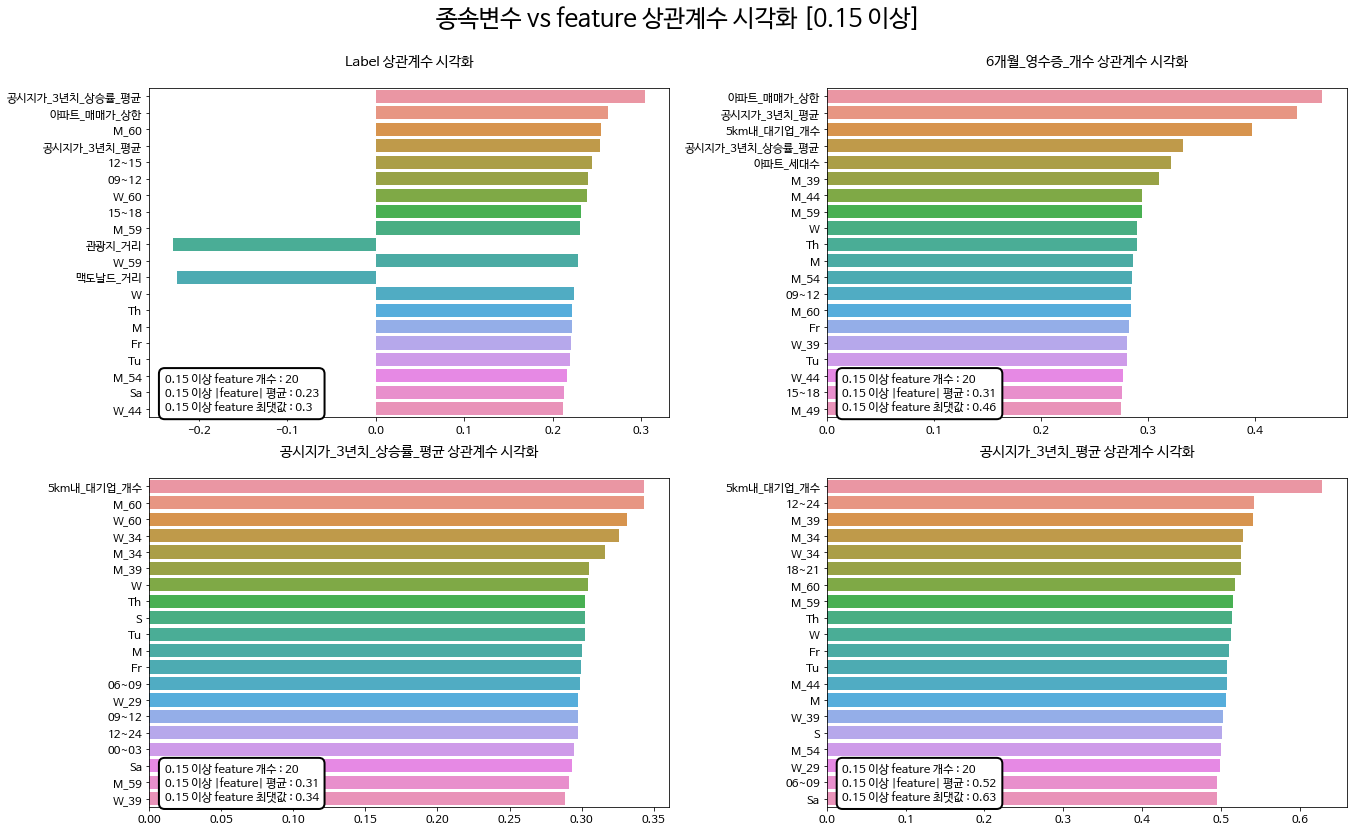

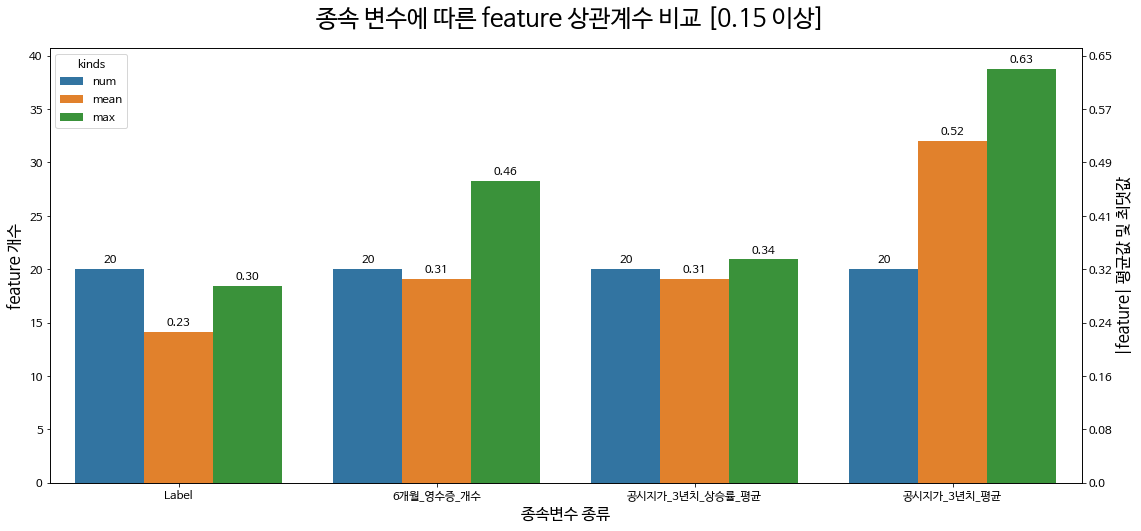

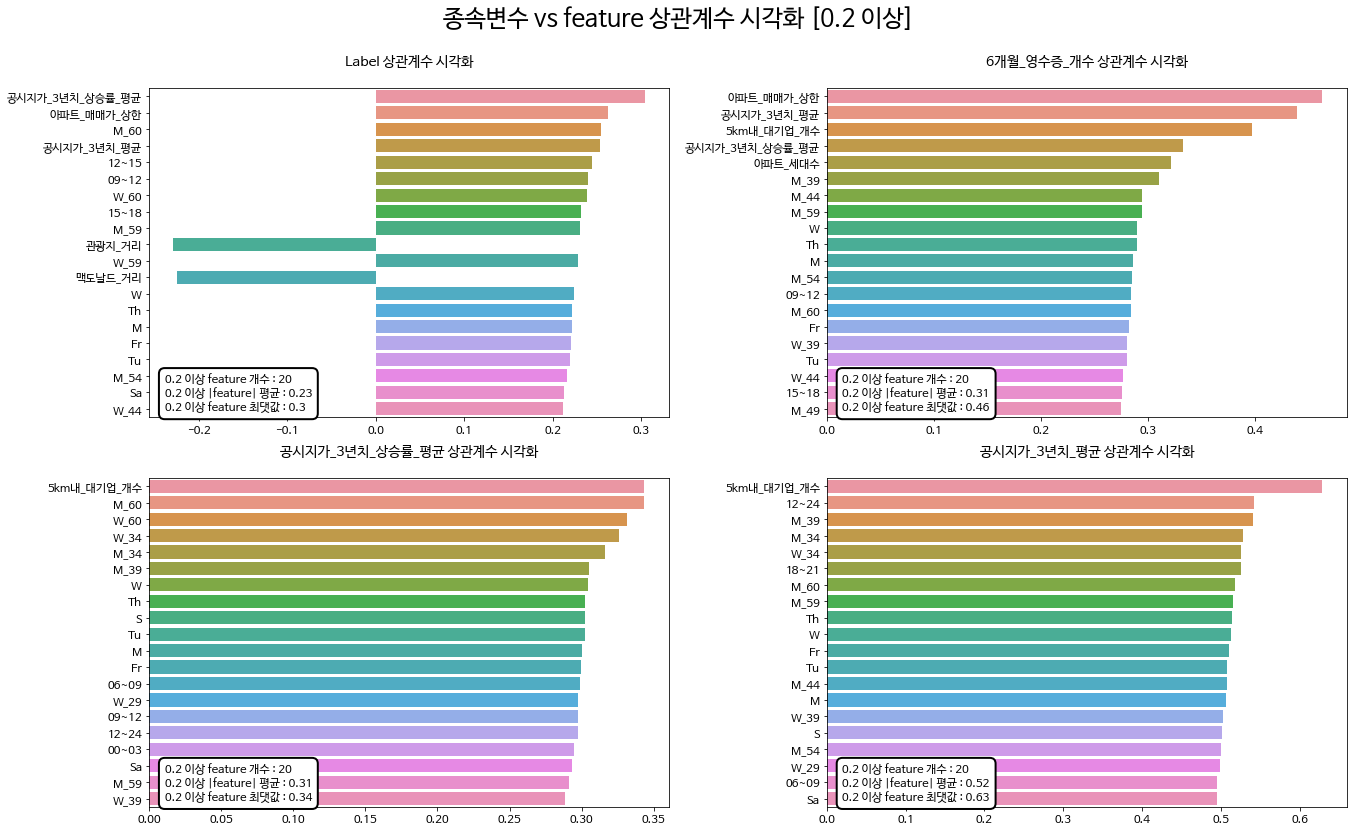

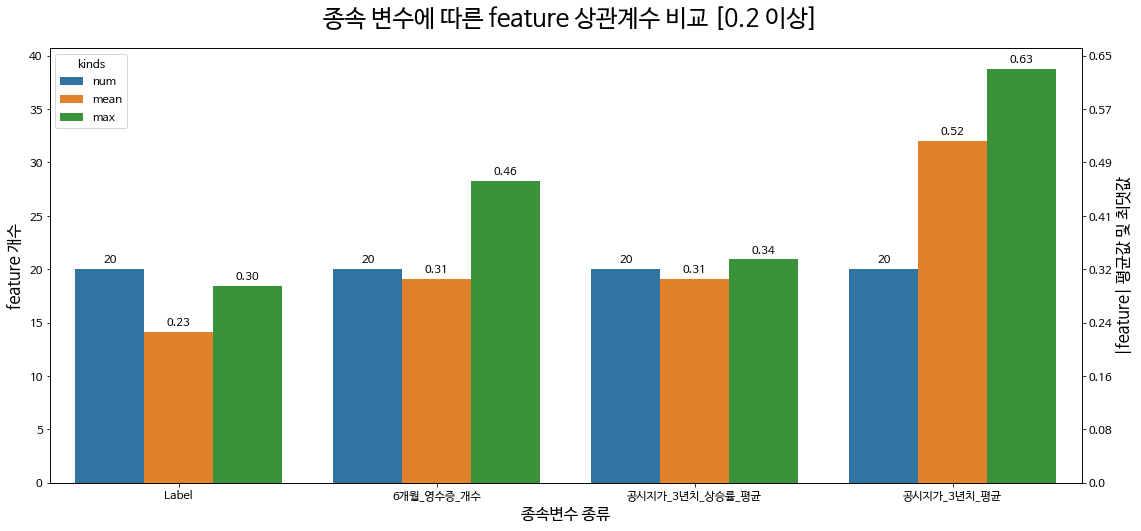

In [283]:
label_cols = ['Label', '6개월_영수증_개수', '공시지가_3년치_상승률_평균', '공시지가_3년치_평균']
feature_cols = ready_feature_col_wrt_corr(replaced_df, label_cols)

## regression metrics

In [447]:
from sklearn import model_selection
from sklearn.metrics import mean_absolute_error, mean_squared_error
from matplotlib import gridspec

def RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
def MPE(y_true, y_pred): 
    return np.mean((y_true - y_pred) / y_true) * 100
def MAPE(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [549]:
class ML_Regression(object):
    def __init__(self, df, model, features, target_label, cv='loocv'):
        self.df = df
        self.model = model
        self.model_name = str(model[1].__class__).split('.')[-1].split("'")[0]
        self.features = features
        self.target_label = target_label
        self.metrics = {'mpe':MPE,
                        'mape':MAPE,
                        'mae':mean_absolute_error,
                        'mse':mean_squared_error}
        self.scores = {x:[] for x in self.metrics.keys()}
        self.scores['지점명'] = []
        self.scores['모델명'] = []
        self.feature_importances = {x:[] for x in self.features}
        self.lines = {'pred':[],'true':[]}
        if cv=='loocv':
            self.cv = model_selection.LeaveOneOut()
        else:
            self.cv = Kfold(k=10)
        
    def modeling(self):
        x_train = self.df[self.features]
        y_train = self.df[self.target_label]

        for train_idx, test_idx in self.cv.split(x_train, y=y_train):
            x_train_part = x_train.iloc[train_idx]
            y_train_part = y_train.iloc[train_idx]
            x_test_part = x_train.iloc[test_idx]
            y_test_part = y_train.iloc[test_idx]
            self.model = self.model.fit(x_train_part[self.features], y_train_part)
            self.scores['지점명'].append(self.df['지점명'][test_idx[0]])
            self.scores['모델명'].append(self.model_name)
            y_pred_part = model.predict(x_test_part[self.features])
            self.lines['pred'].append(y_pred_part[0])
            self.lines['true'].append(y_test_part.values[0])
            
            for fea, val in zip(self.features, self.model[1].feature_importances_):
                self.feature_importances[fea].append(val)
                
            for metric_name, metric in self.metrics.items():
                self.scores[metric_name].append(metric(y_test_part, y_pred_part))
                
    def visualize_error(self, text, point_plot=False):
        x_related, y_related = text.split(' ')
        if (x_related == '015') or (x_related == '02'):
            x_related = '0.'.join(x_related.split('0')) + '이상'

        self.scores_df = pd.DataFrame(self.scores)
        self.key_score = self.scores_df.groupby('모델명').mean()[['mae','mse']]
        self.key_score['rmse'] = np.sqrt(self.scores_df.mse.sum())/self.scores_df.shape[0]
        if point_plot:
            fig, axs = plt.subplots(3, 1)
            fig.suptitle(f"feature {x_related}, target 변수 : {y_related}", y=1.02, fontsize=16)

            test = pd.melt(self.scores_df.reset_index().loc[:, ['index', 'mae', 'mse']], id_vars=['지점명', 'index'], value_vars=['mae', 'mse'], var_name='error')
            ax = sns.pointplot(x='index', y='value', hue='error', data=test, palette='Set1', ax=axs[0])
            ax.xaxis.set_ticklabels([])
            axs[0].set_xlabel('data index', size=14)
            axs[0].set_ylabel('error value', size=14)

            test = pd.melt(self.scores_df.reset_index().loc[:, ['index', 'mpe', 'mape']], id_vars=['지점명', 'index'], value_vars=['mpe', 'mape'], var_name='error')
            ax = sns.pointplot(x='index', y='value', hue='error', data=test, palette='Set2', ax=axs[1])
            ax.xaxis.set_ticklabels([])
            axs[1].set_xlabel('data index', size=14)
            axs[1].set_ylabel('error value', size=14)

            sns.barplot(x=self.model_name, y='index', data=self.key_score.T.reset_index().sort_values(self.model_name, ascending=True),
                        palette="rocket", ax=axs[2])
            axs[2].set_ylabel('error', size=14)
            axs[2].set_xlabel('value', size=14)
            self.add_bar_text(axs[2])
            fig.set_size_inches(10,10)
        else:
            fig, ax = plt.subplots()
            fig.suptitle(f"feature {x_related}, target 변수 : {y_related}", y=1.02, fontsize=16)
            sns.barplot(x=self.model_name, y='index', data=self.key_score.T.reset_index().sort_values(self.model_name, ascending=True),
            palette="rocket_r", ax=ax)
            ax.set_ylabel('error', size=14)
            ax.set_xlabel('value', size=14)
            self.add_bar_text(ax)
            fig.set_size_inches(12,3)
        fig.tight_layout()

    def get_density(self, x, y):
        x = np.array(x)
        y = np.array(y)
        xy = np.vstack([x, y])
        z = gaussian_kde(xy)(xy)
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]
        density = pd.DataFrame({'pred':x, 'true':y, 'density':z})
        return density
    
    def add_bar_text(self, ax):
        for idx, patch in enumerate(ax.patches):
            value = f'{patch.get_width():.3f}'
            print(f'x : {patch.get_x():.3f}, y: {patch.get_y():.3f}, w: {patch.get_width():.3f}, h: {patch.get_height():.3f}')
            ax.annotate(value, 
                        (patch.get_x() + patch.get_width() , patch.get_y() + patch.get_height() / 2.), 
                        ha = 'left', va = 'center', 
                        xytext = (0, 0), 
                        textcoords = 'offset points',
                        size=12) 
            
    def plot_result_error(self, text):
        bbox_props = dict(boxstyle="round,pad=0.5", fc="w", ec="k", lw=2)
        density = self.get_density(self.lines['true'], self.lines['pred'])
        
#         errors = ['importances_mse_min', 'importances_mae_min', 'importances_mean']
        errors = ['importances_mean']
        nrows = 1+len(errors)
        fig, axs = plt.subplots(nrows, 1)
        
        sns.scatterplot('true', 'pred', data=density, hue='density', edgecolor='', ax=axs[0], legend='brief')
        ax = sns.lineplot(np.linspace(0, 1, 30), np.linspace(0, 1, 30), color='red', ax=axs[0])
        ax.lines[0].set_linestyle("--")

        axs[0].set_title('pred vs true plot', fontsize=16)
        axs[0].set_xlabel('real value', size=14)
        axs[0].set_ylabel('pred value', size=14)
        axs[0].annotate(f"mse : {self.key_score.iloc[0,:]['mse']:.2f}\n"
                        f"rmse : {self.key_score.iloc[0,:]['rmse']:.2f}\n"
                        f"mae : {self.key_score.iloc[0,:]['mae']:.2f}",
                        xy=(0.8, 0.6),
                        xycoords='axes fraction',
                        xytext=(0.8, 0.6),
                        bbox=bbox_props,
                        size=14)

        score_df = pd.DataFrame(self.scores)
        feature_importance_df = pd.DataFrame(self.feature_importances)
        
        feature_df = pd.DataFrame()
        feature_df['features'] = list(feature_importance_df.columns)
        if len(errors) > 1:
            feature_df['importances_mse_min'] = feature_importance_df.loc[score_df.mse.idxmin()].values
            feature_df['importances_mae_min'] = feature_importance_df.loc[score_df.mae.idxmin()].values
        feature_df['importances_mean'] = feature_importance_df.mean().values
        for idx, kind in enumerate(errors):
            feature_df = feature_df.sort_values(kind, ascending=False).reset_index(drop=True)
            feature_df_top10 = feature_df.iloc[:10]
#             print(feature_df_top10)
            sns.barplot(y=feature_df_top10['features'], x= feature_df_top10[kind], ax=axs[idx+1], palette='twilight_shifted_r')

            axs[idx+1].set_xlabel('중요도', size=14)
            axs[idx+1].set_ylabel('features', size=14)
            axs[idx+1].set_title(f'{kind}', size=16)

        x_related, y_related = text.split(' ')
        if (x_related == '015') or (x_related == '02'):
            x_related = '0.'.join(x_related.split('0')) + '이상'
        fig.suptitle(f"feature {x_related}, target 변수 : {y_related}", y=1.01, fontsize=16)
        fig.set_size_inches(8, nrows*5)
        fig.tight_layout()


## modeling and result visualization

x : 0.000, y: -0.400, w: 0.019, h: 0.800
x : 0.000, y: 0.600, w: 0.032, h: 0.800
x : 0.000, y: 1.600, w: 0.134, h: 0.800


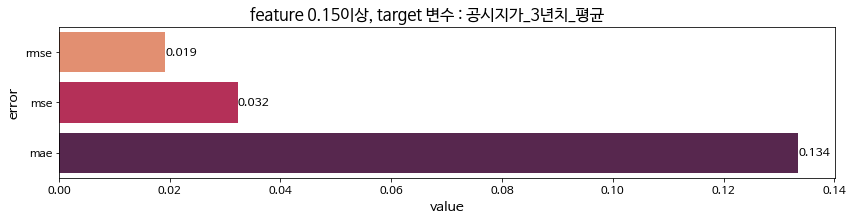

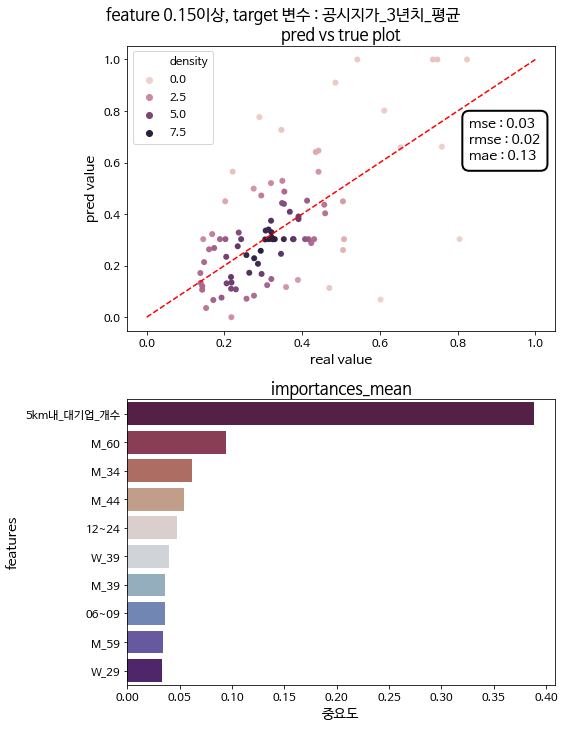

In [551]:
key_scores = {}
total_scores = {}
feature_importances = {}
ml_pipelines = []
replaced_df_temp = replaced_df.copy()
# independets = ['all', '015']
# dependents = ['6개월_영수증_개수', '공시지가_3년치_평균']
independets = ['015']
dependents = ['공시지가_3년치_평균']
for independet in independets:
    for dependent in dependents:
        model = Pipeline([('scaler',MinMaxScaler()), ('random_forest', RandomForestRegressor(random_state=0))])
        replaced_df_temp[dependent] = (replaced_df_temp[dependent]-replaced_df_temp[dependent].min())/(replaced_df_temp[dependent].max()-replaced_df_temp[dependent].min())
        ml_pipeline = ML_Regression(replaced_df_temp, model, feature_cols[independet][dependent], dependent, cv='loocv')
        ml_pipeline.modeling()
        ml_pipeline.visualize_error(text=independet+' '+dependent)
        ml_pipeline.plot_result_error(text=independet+' '+dependent)
        ml_pipelines.append(ml_pipeline)

# 성능 분석 1. Label과 상관관계가 높은 변수 분석

In [216]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np

class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

length_of_features : 15, n_rows : 4


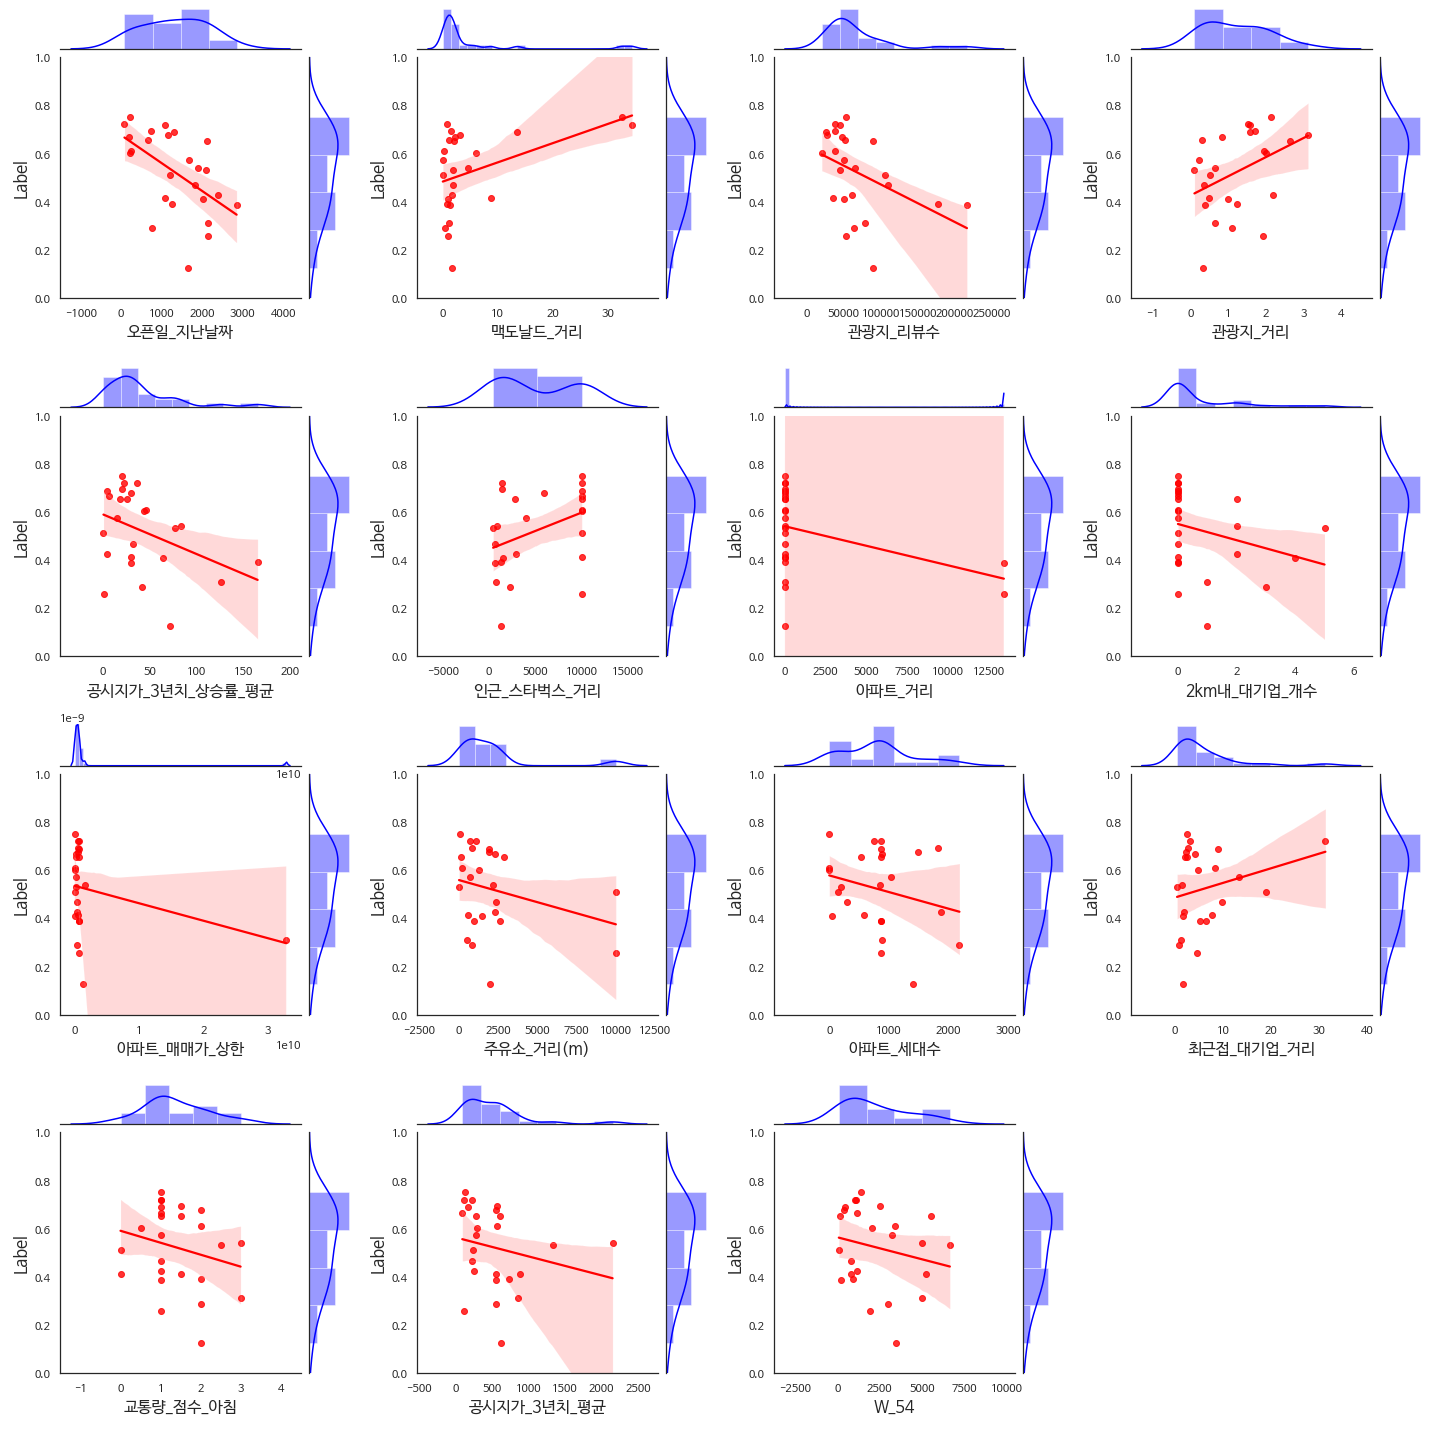

In [240]:
def visualize_feature_wrt_target(df, features, target_feature, ncols=3):
    length_of_features = len(features)
    nrows, r = divmod(length_of_features, ncols)
    
    if r > 0:
        nrows += 1  
    print(f'length_of_features : {length_of_features}, n_rows : {nrows}')
    fig = plt.figure(figsize=(20,20))
    gs = gridspec.GridSpec(nrows, ncols)
#     colors = np.random.random((len(features),3))
    for idx, feature in enumerate(features):
        g = sns.jointplot(x=df[feature],y=df[target_feature], kind='reg', space=0, ylim=[0,1], color="blue")
        g.ax_joint.cla()

        ax = sns.regplot(df[feature], df[target_feature], ax=g.ax_joint, color='red')
        ax.set_ylim([0, 1])
        g.set_axis_labels(feature, target_feature, fontsize=16)
        mg = SeabornFig2Grid(g, fig, gs[idx])
        
    fig = plt.gcf()
    gs.tight_layout(fig)
    plt.show()
    fig.suptitle(f"feature에 따른 {target_feature}", fontsize=16)
        
visualize_feature_wrt_target(stDT.trip, top_values['Label'].keys(), 'Label', 4)

학습 평균 score = 0.97287838, 검증 평균 score = -7.08673839
*************** 6개월_영수증_개수 complete ***************

학습 평균 score = 0.93873954, 검증 평균 score = -3.02873418
*************** 6개월_영수증_개수 complete ***************

학습 평균 score = 0.89238852, 검증 평균 score = -1.51400816
*************** 6개월_영수증_개수 complete ***************

k = 3 is best for 6개월_영수증_개수

학습 평균 score = 0.96474481, 검증 평균 score = -15.40728327
*************** Label complete ***************

학습 평균 score = 0.91939791, 검증 평균 score = -8.00147178
*************** Label complete ***************

학습 평균 score = 0.88563619, 검증 평균 score = -3.72696810
*************** Label complete ***************

k = 3 is best for Label



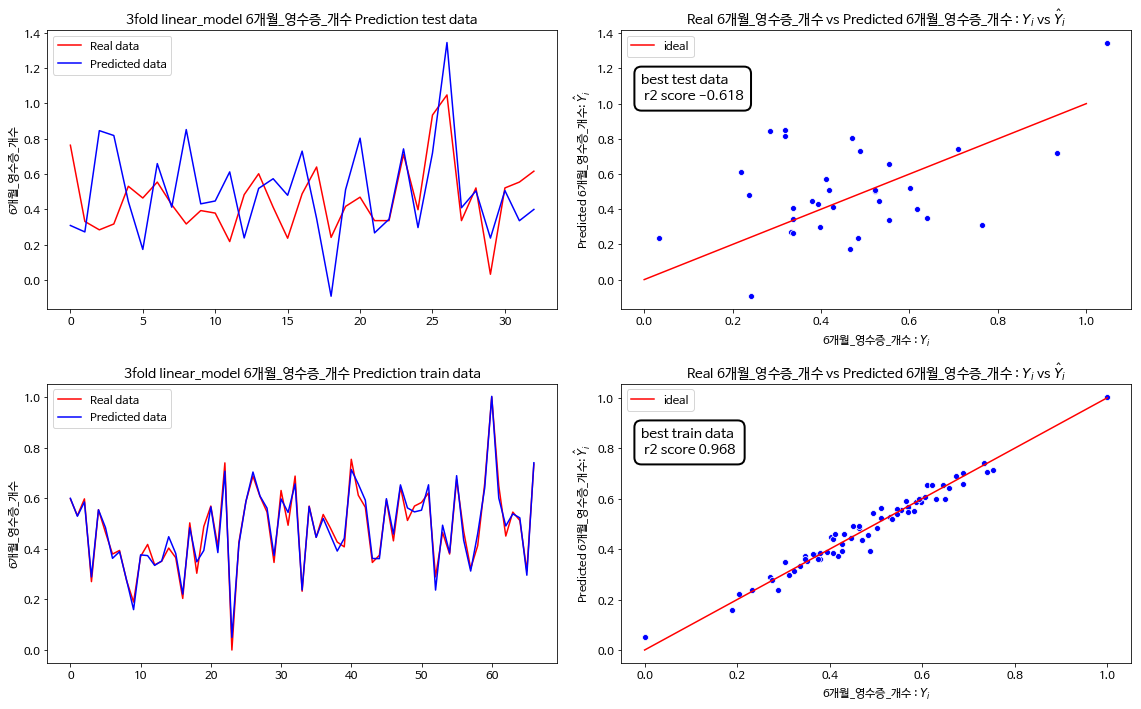

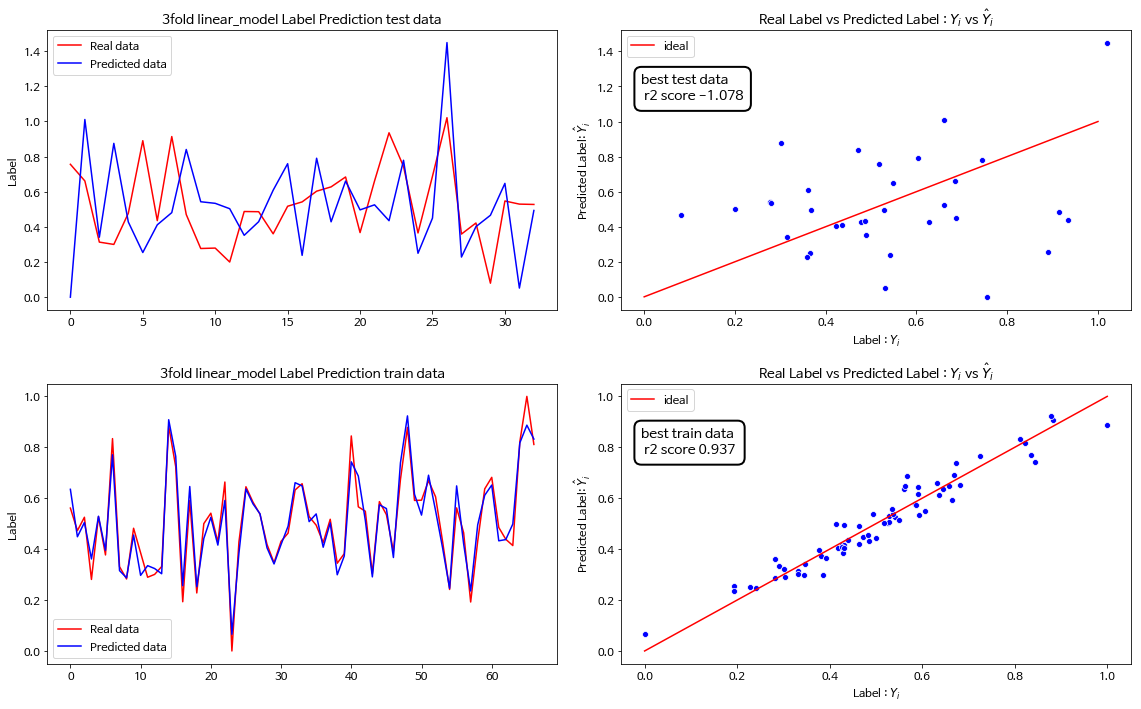

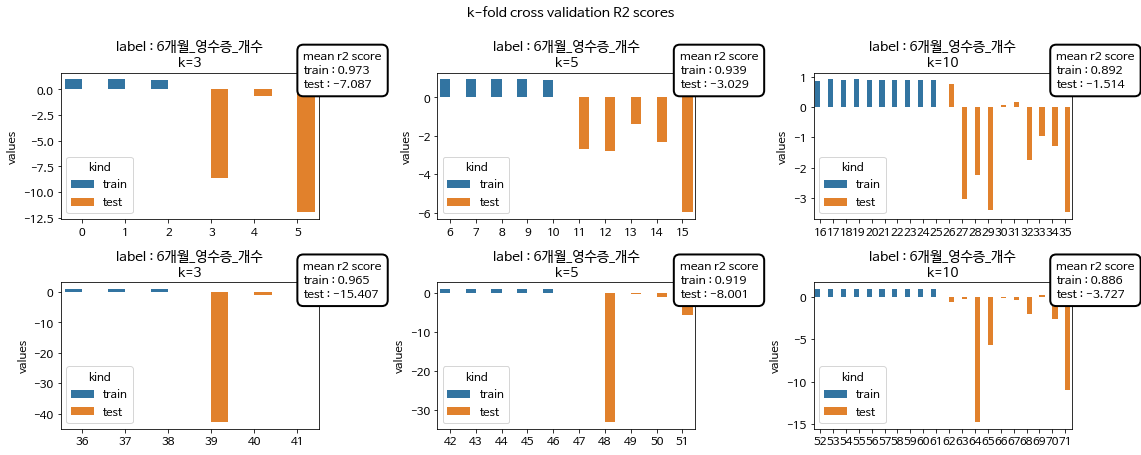

In [376]:
kfold_model['apt'], kfold_results['apt'] = supervised_modeling(stDT.apt, linear_model, 'linear_model', feature_names, target_lables)

## 사업체

학습 평균 score = 1.00000000, 검증 평균 score = -3.62096640
*************** 6개월_영수증_개수 complete ***************

학습 평균 score = 1.00000000, 검증 평균 score = -55.85731480
*************** 6개월_영수증_개수 complete ***************

학습 평균 score = 1.00000000, 검증 평균 score = -8495.62267973
*************** 6개월_영수증_개수 complete ***************

k = 3 is best for 6개월_영수증_개수

학습 평균 score = 1.00000000, 검증 평균 score = -5.67486873
*************** Label complete ***************

학습 평균 score = 1.00000000, 검증 평균 score = -18.77346639
*************** Label complete ***************

학습 평균 score = 1.00000000, 검증 평균 score = -118.21817639
*************** Label complete ***************

k = 3 is best for Label



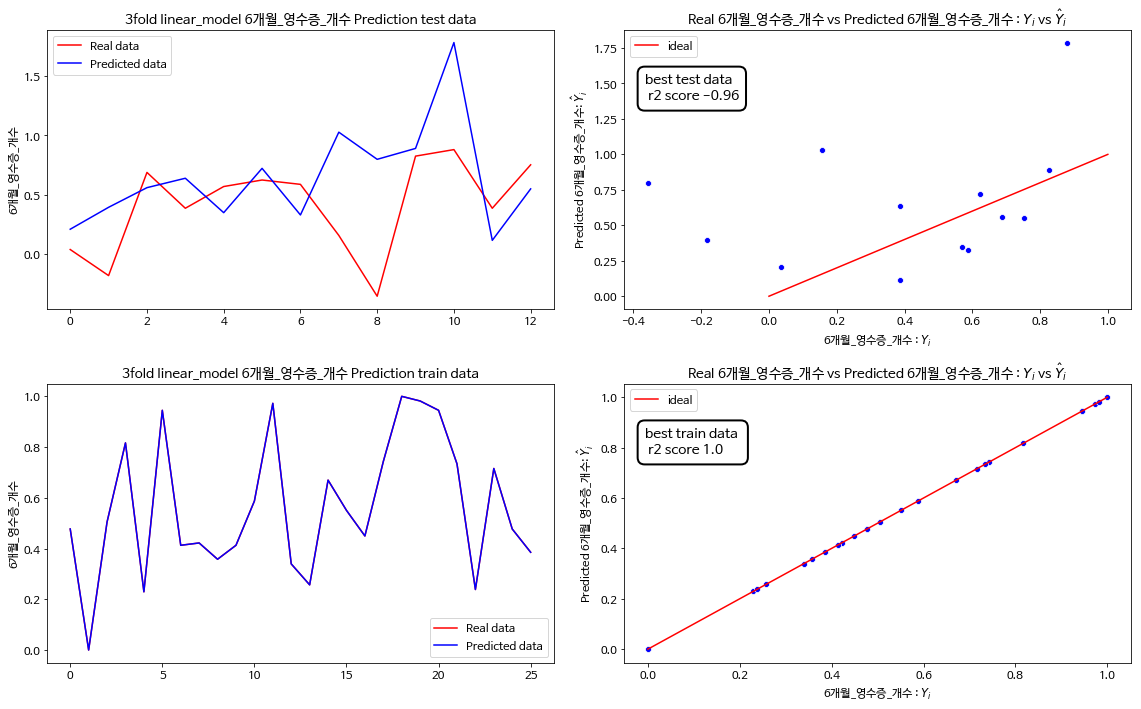

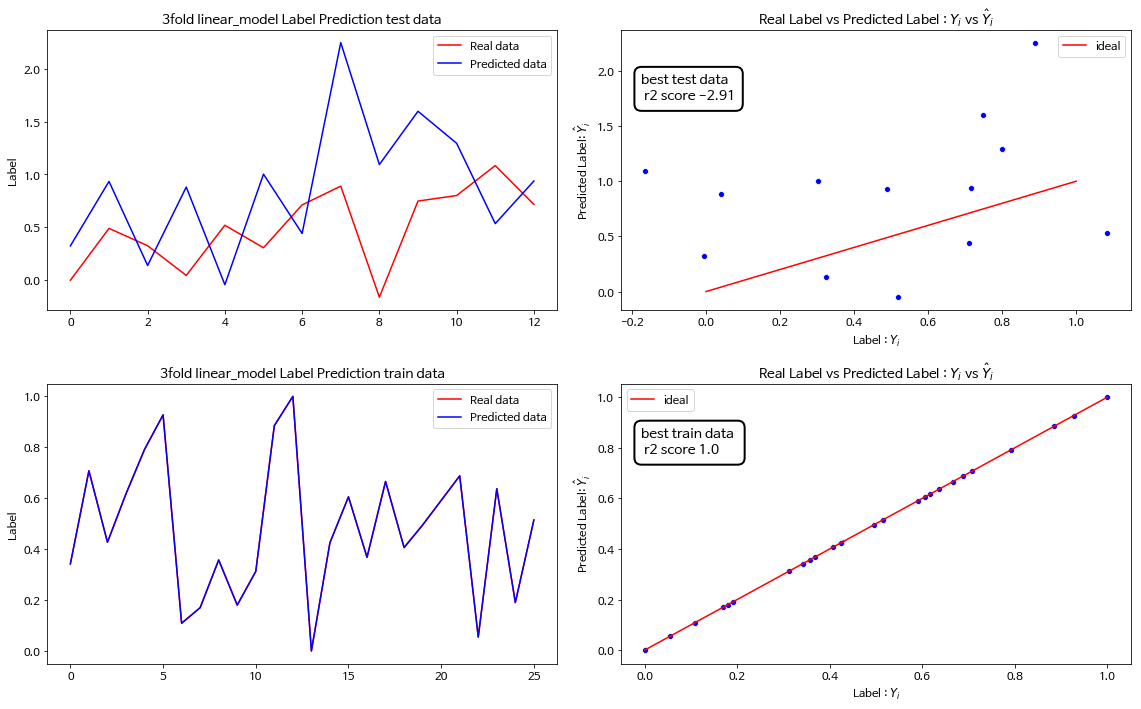

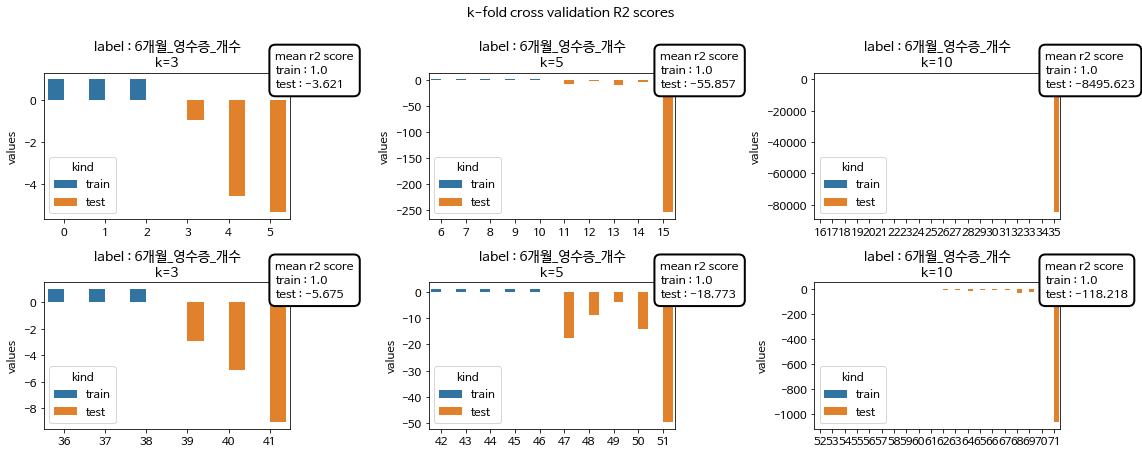

In [377]:
kfold_model['company'], kfold_results['company'] = supervised_modeling(stDT.company, linear_model, 'linear_model', feature_names, target_lables)

this 6개월_점수 has not important features


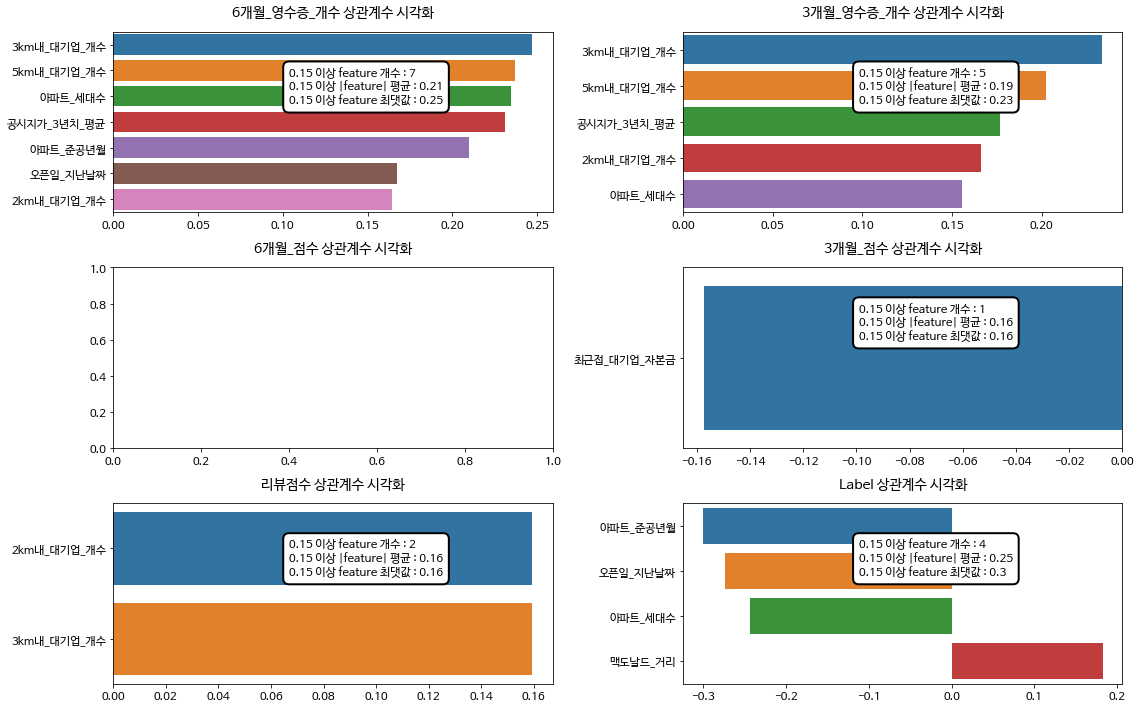

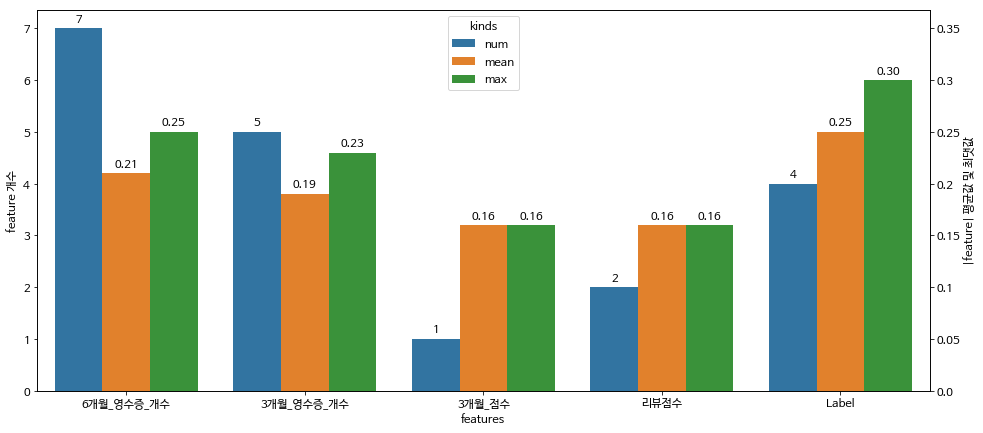

In [243]:
feature_df = visualize_feature_importance(corr_df, label_cols, except_cols)